In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

In [ ]:
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [ ]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)
    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)
    du_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 0)
    du_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 0)
    dv_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 1)
    dv_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 1)

    pde_u = Y[:,0:1]*du_x + Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho)*(du_xx + du_yy)
    pde_v = Y[:,0:1]*dv_x + Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho)*(dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]


In [ ]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

In [ ]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v],
                    num_domain = 3000,
                    num_boundary = 500,
                    num_test = 1000,
                    train_distribution = 'LHS' )


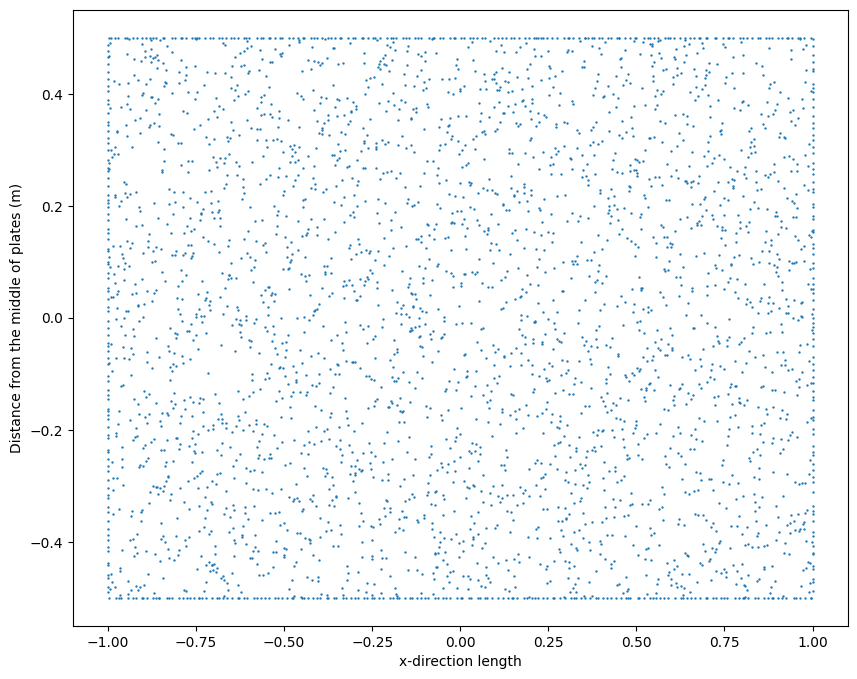

In [ ]:
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

In [ ]:
layer_size = [2] + [64] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr = 1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.122986 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.862233 s



Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [5.94e-02, 1.70e-01, 4.81e-02, 1.12e-02, 7.57e-03, 7.22e-01, 1.88e-02, 7.16e-02, 1.89e-02]    [6.07e-02, 1.73e-01, 4.93e-02, 1.12e-02, 7.57e-03, 7.22e-01, 1.88e-02, 7.16e-02, 1.89e-02]    []  
1000      [1.92e-03, 9.01e-04, 8.35e-03, 3.10e-02, 1.63e-02, 3.79e-02, 1.48e-03, 4.75e-04, 1.76e-05]    [1.85e-03, 5.73e-04, 5.77e-03, 3.10e-02, 1.63e-02, 3.79e-02, 1.48e-03, 4.75e-04, 1.76e-05]    []  
2000      [3.65e-03, 2.09e-03, 4.94e-03, 2.40e-02, 1.34e-02, 2.84e-02, 1.27e-03, 1.41e-04, 1.28e-04]    [2.80e-03, 1.98e-03, 3.20e-03, 2.40e-02, 1.34e-02, 2.84e-02, 1.27e-03, 1.41e-04, 1.28e-04]    []  
3000      [2.06e-02, 4.72e-03, 3.34e-03, 2.05e-02, 1.11e-02, 2.32e-02, 3.19e-03, 4.81e-03, 1.03e-04]    [1.85e-02, 4.16e-03, 2.19e-03, 2.05e-02, 1.11e-02, 2.32e-0

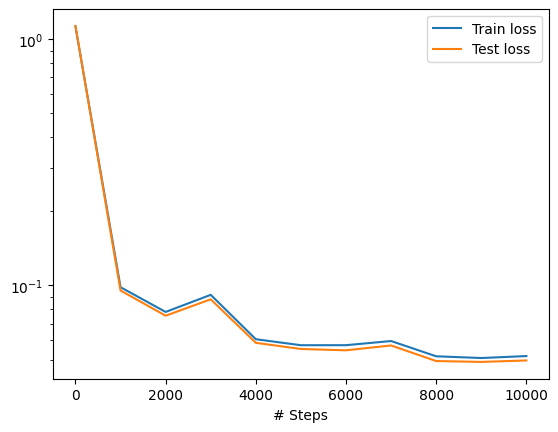

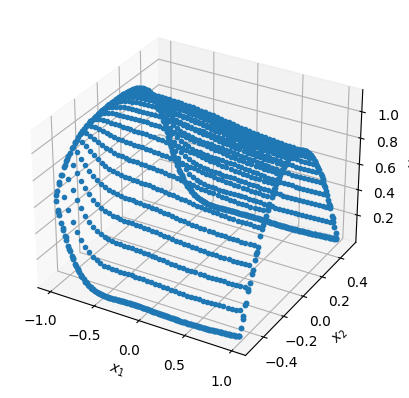

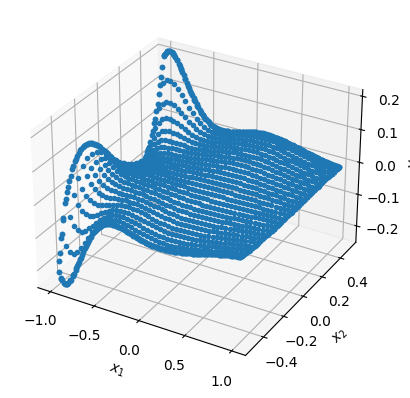

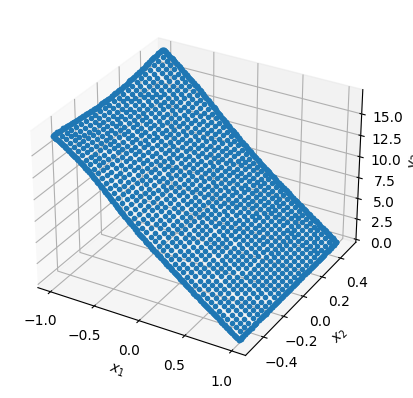

In [ ]:
losshistory, train_state = model.train(epochs = 10000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

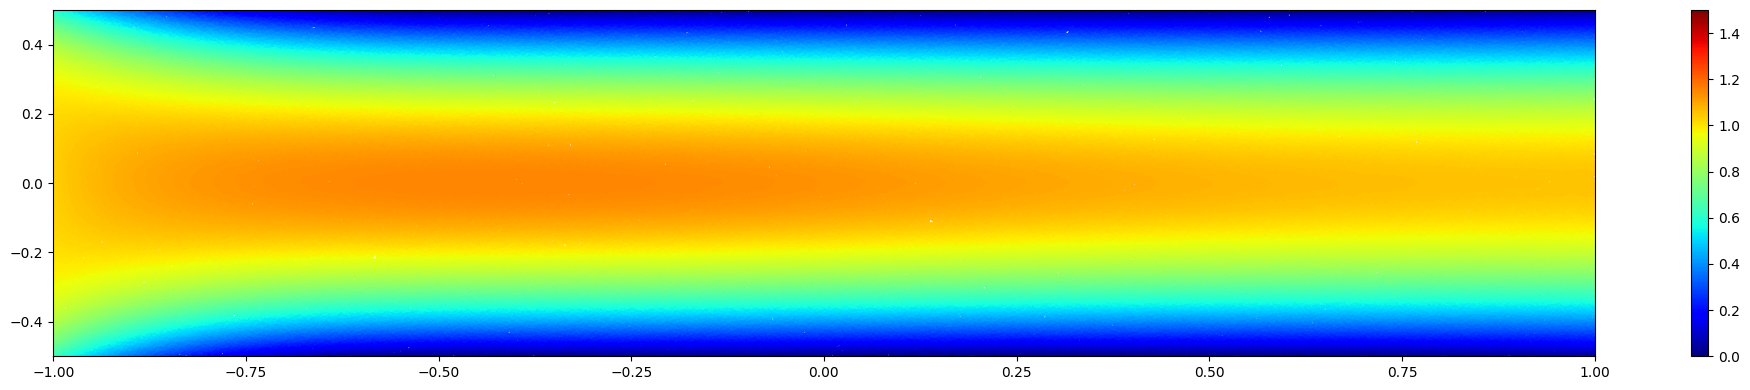

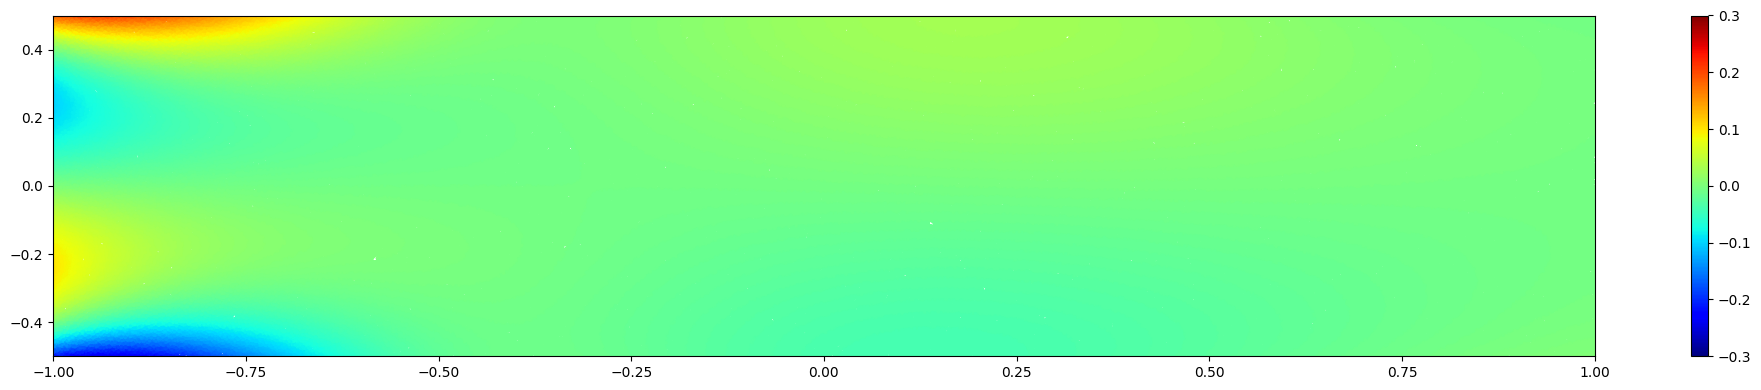

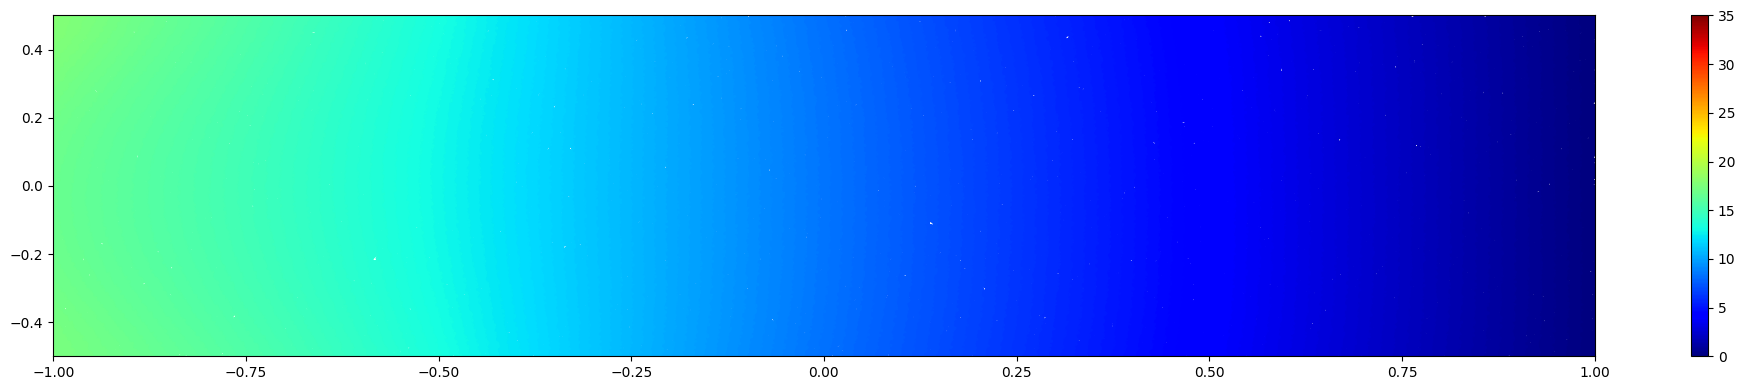

In [ ]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

Compiling model...
'compile' took 1.087070 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [3.42e-03, 1.11e-03, 2.16e-03, 1.71e-02, 6.11e-03, 1.55e-02, 6.17e-03, 4.40e-05, 2.41e-05]    [2.42e-03, 1.02e-03, 1.18e-03, 1.71e-02, 6.11e-03, 1.55e-02, 6.17e-03, 4.40e-05, 2.41e-05]    []  
11000     [8.38e-04, 5.71e-04, 1.34e-03, 1.11e-02, 1.21e-03, 7.03e-03, 2.18e-03, 1.09e-05, 1.03e-05]    [8.38e-04, 5.71e-04, 1.34e-03, 1.11e-02, 1.21e-03, 7.03e-03, 2.18e-03, 1.09e-05, 1.03e-05]        
12000     [4.86e-04, 3.77e-04, 7.04e-04, 7.20e-03, 1.19e-03, 5.61e-03, 1.68e-03, 2.28e-05, 1.44e-06]    [4.86e-04, 3.77e-04, 7.04e-04, 7.20e-03, 1.19e-03, 5.61e-03, 1.68e-03, 2.28e-05, 1.44e-06]        
13000     [5.85e-04, 4.26e-04, 5.74e-04, 5.36e-03, 1.21e-03, 4.04e-03, 1.46e-03, 3.61e-05, 5.07e-06]    [5.85e-04, 4

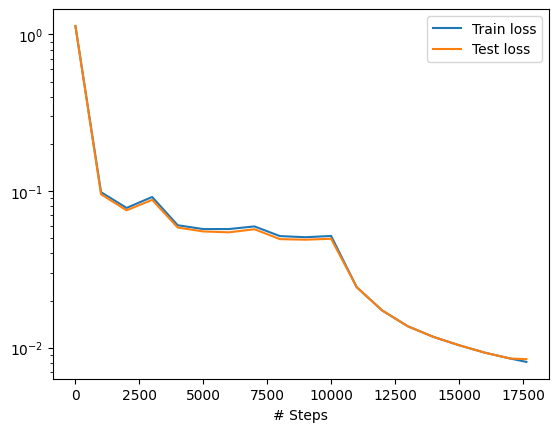

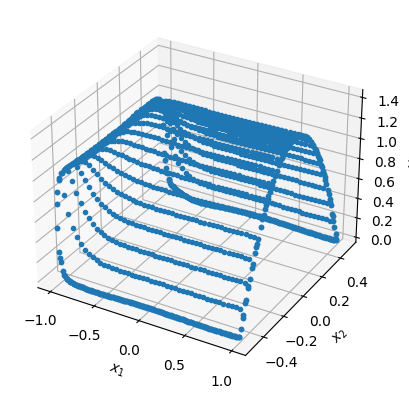

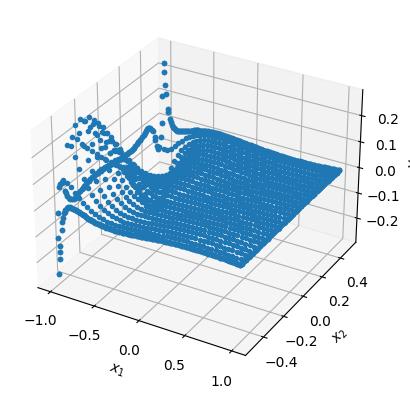

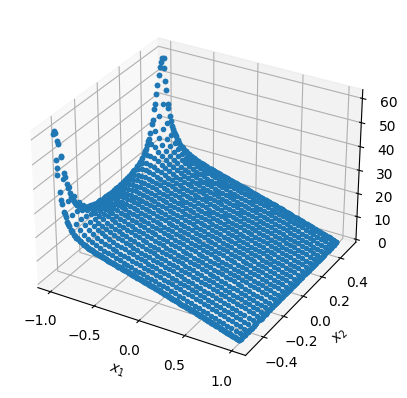

In [ ]:
dde.optimizers.config.set_LBFGS_options()

model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

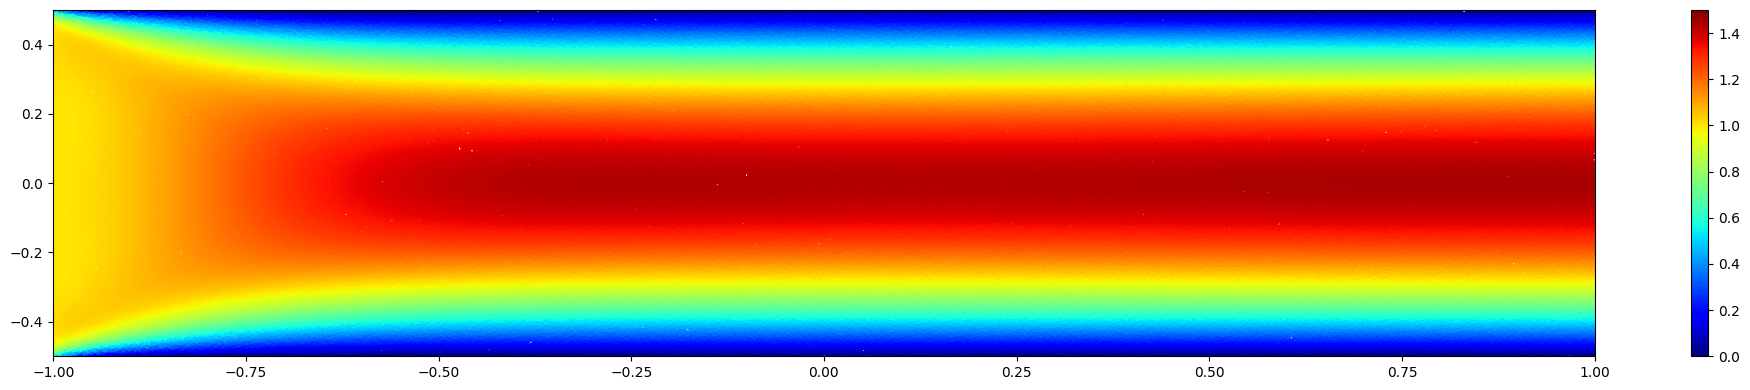

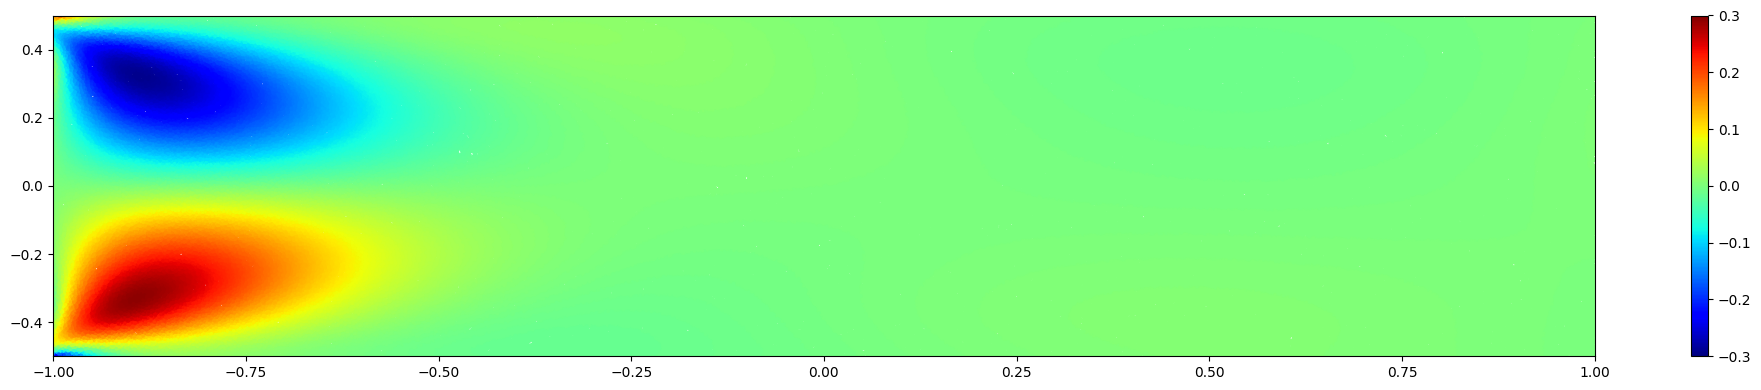

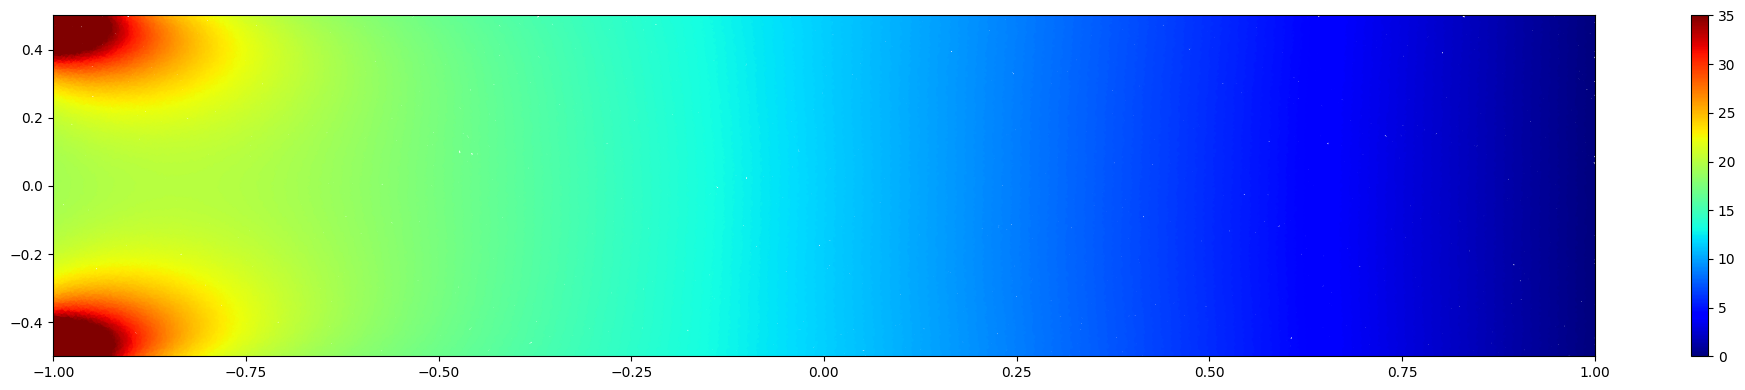

In [ ]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

In [ ]:
# Analytic solution
x = np.ones([1000,1])
y = np.linspace(-0.5, 0.5, 1000).reshape(1000,1)
outlet = np.hstack([x, y])

analytic_solution = u_in * 1.5 * (1 - ((y)/(D/2))**2)

PINN_solution = model.predict(outlet)

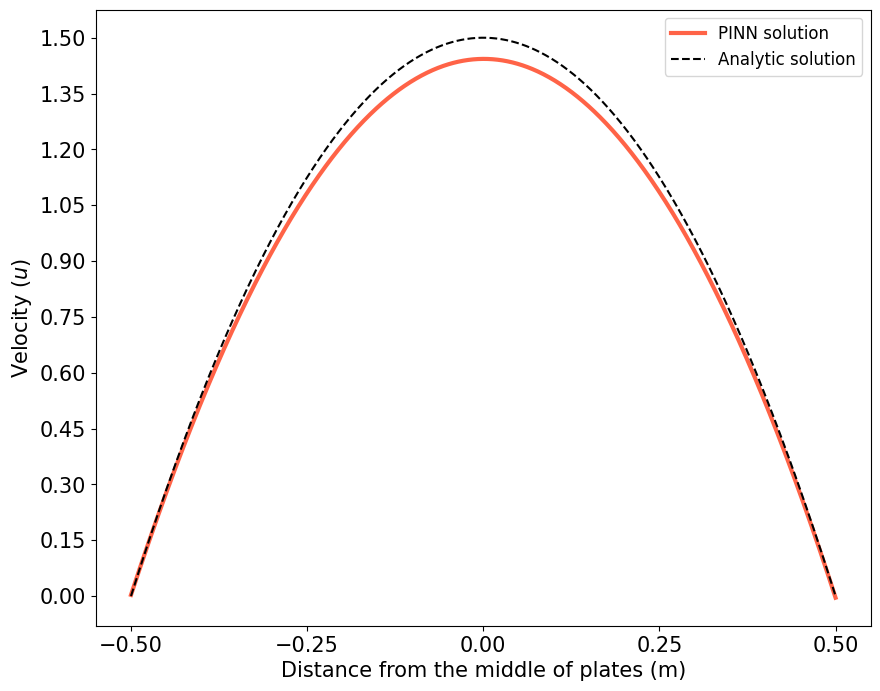

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(y, PINN_solution[:, 0], c = 'tomato', linewidth = 3, label = 'PINN solution')
plt.plot(y, analytic_solution, c = 'k', linestyle = '--', label = 'Analytic solution')
plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize = 15)
plt.yticks(np.linspace(0, 1.5, 11), fontsize = 15)
plt.legend(fontsize = 12)
plt.xlabel('Distance from the middle of plates (m)', fontsize = 15)
plt.ylabel('Velocity ($u$)', fontsize = 15)
plt.show()